In [36]:
import pandas as pd
import numpy as np 
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable

In [37]:
data_path = 'cleaned_data/solar_data_january_1min_2023_timestamp.csv'
df = pd.read_csv(data_path, sep= ';')

In [38]:
X = df['Timestamp'].values.reshape(-1,1)
y = df[['Azimuth', 'Altitude']].values

In [39]:
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = torch.FloatTensor(X_scaled).view(-1, 1, 1).to(device)
y_tensor = torch.FloatTensor(y_scaled).to(device)

In [41]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [42]:
#Define RNN-LSTM model 
class RNNLSTMModel(nn.Module):
    def __init__(self, input_size = 1 , rnn_hidden_size=128, lstm_hidden_size=512, output_size = 2, num_layers=4):
        super().__init__()
        self.rnn_hidden_size = rnn_hidden_size
        self.lstm_hidden_size = lstm_hidden_size
        self.num_layers = num_layers
                
        # RNN Layer 
        self.rnn = nn.RNN (input_size, rnn_hidden_size, num_layers, batch_first=True, dropout = 0.2)

        #LSTM Layer
        self.lstm = nn.LSTM(rnn_hidden_size, lstm_hidden_size, num_layers, batch_first= True, dropout = 0.2)

        # Batch Normalization layer
        self.batch_norm = nn.BatchNorm1d(lstm_hidden_size)

        # Linear Layout
        self.linear = nn.Linear(lstm_hidden_size, output_size)

        # Leaky ReLU Activation
        self.activation = nn.LeakyReLU()

    def forward(self, input_seq):
        h0_rnn = torch.zeros(self.num_layers, input_seq.size(0), self.rnn_hidden_size).to(device)
        rnn_out, _ = self.rnn(input_seq, h0_rnn)

        h0_lstm = torch.zeros(self.num_layers, input_seq.size(0), self.lstm_hidden_size).to(device)
        c0_lstm = torch.zeros(self.num_layers, input_seq.size(0), self.lstm_hidden_size).to(device)
        lstm_out, _ = self.lstm(rnn_out, (h0_lstm, c0_lstm))

        # Apply Batch Normalization
        lstm_out = self.batch_norm(lstm_out[:, -1, :])

        predictions = self.linear(self.activation(lstm_out))
        return predictions

In [43]:
# Instantiate the RNN-LSTM model, move it to GPU, define loss function, and optimizer
model = RNNLSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [44]:
# Train the model
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)

    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


Epoch 10/50, Loss: 0.12938375771045685
Epoch 20/50, Loss: 0.1271807849407196
Epoch 30/50, Loss: 0.12622900307178497
Epoch 40/50, Loss: 0.12564121186733246
Epoch 50/50, Loss: 0.12535427510738373


In [45]:
# Evaluation on test data
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_val_pred = model(X_val)

In [46]:
# Inverse transform the predictions to original scale
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred.cpu().numpy())
y_val_pred_inv = scaler_y.inverse_transform(y_val_pred.cpu().numpy())
y_test_actual_inv = scaler_y.inverse_transform(y_test.cpu().numpy())

In [47]:
# Inverse transform the actual test data to original scale
y_test_actual_inv = scaler_y.inverse_transform(y_test.cpu().numpy())

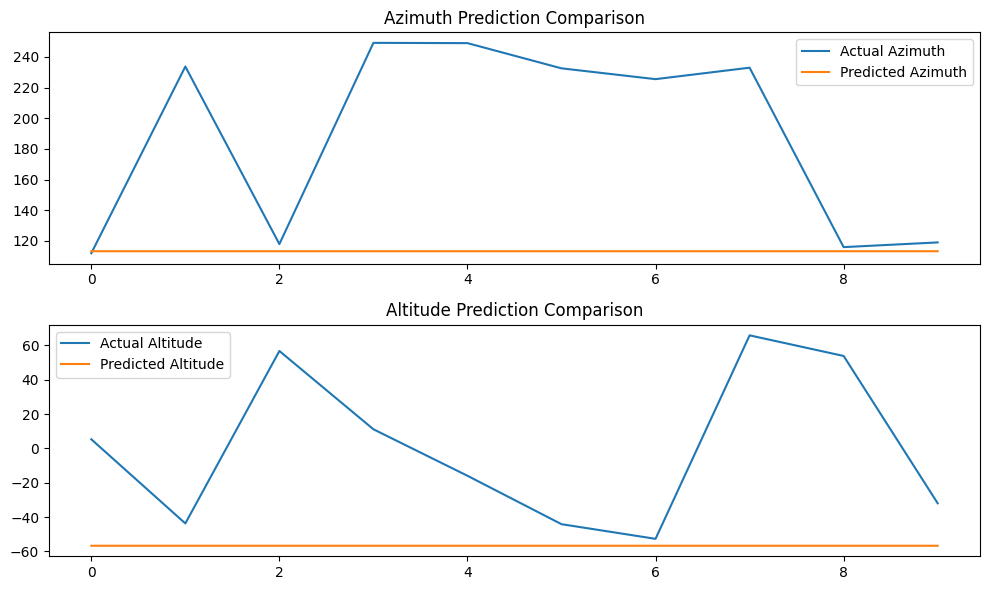

In [48]:
# Plotting
plt.figure(figsize=(10, 6))

# Azimuth Comparison
plt.subplot(2, 1, 1)
plt.plot(y_test_actual_inv[:10, 0], label='Actual Azimuth')
plt.plot(y_test_pred_inv[:10, 0], label='Predicted Azimuth')
plt.legend()
plt.title('Azimuth Prediction Comparison')

# Altitude Comparison
plt.subplot(2, 1, 2)
plt.plot(y_test_actual_inv[:10, 1], label='Actual Altitude')
plt.plot(y_test_pred_inv[:10, 1], label='Predicted Altitude')
plt.legend()
plt.title('Altitude Prediction Comparison')

plt.tight_layout()
plt.show()